In [1]:
import os
import sys
import copy
import random
import json
import yaml
import glob
import cv2
import numpy as np
import time
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from   zipfile import ZipFile
%matplotlib inline
import pandas as pd
import logging
import torch

# Set up logging
logging.basicConfig(level=logging.INFO)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
def download_and_unzip(url, save_path, extract_dir):
    print("Downloading assets...")
    file = requests.get(url)

    open(save_path, "wb").write(file.content)
    print("Download completed.")

    try:
        if save_path.endswith(".zip"):
            with ZipFile(save_path, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print("Extraction Done")
    except Exception as e:
        print(f"An error occurred: {e}")

def download_image(url):
    filename = os.path.basename(url)

    response = requests.get(url)
    response.raise_for_status()

    with open(filename, 'wb') as file:
        file.write(response.content)

    return os.path.abspath(filename)

def get_basename(path):
  return os.path.basename(path)

def print_fish_data(fish_data):
    for idx, fish in enumerate(fish_data, start=1):
        print(f"ID: {idx}")
        print(f"Name: {fish['name']}")
        print(f"Species ID: {fish['species_id']}")
        print(f"Distance: {fish['distance']:.3f}")
        print(f"Accuracy: {fish['accuracy']:.2%}")
        print("-" * 40)


In [ ]:
# Links to models
MODEL_URLS = {
    'classification': 'https://storage.googleapis.com/fishial-ml-resources/classification_rectangle_v9-3.zip',
    'segmentation': 'https://storage.googleapis.com/fishial-ml-resources/segmentator_fpn_res18_416_1.zip',
    'detection': 'https://storage.googleapis.com/fishial-ml-resources/detector_v10_m5.zip',
    'face': 'https://storage.googleapis.com/fishial-ml-resources/face_yolo.zip'
}

# Model directories
MODEL_DIRS = {
    'classification': "models/classification",
    'segmentation': "models/segmentation",
    'detection': "models/detection",
    'face': "models/face_detector"
}

# Create directories and download models
for model_name, url in MODEL_URLS.items():
    model_dir = MODEL_DIRS[model_name]
    zip_path = os.path.join(os.getcwd(), get_basename(url))

    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    download_and_unzip(url, zip_path, model_dir)  # Download and unzip the model

    # Remove the zip file after extraction
    try:
        os.remove(zip_path)
        logging.info(f"Removed zip file {zip_path}")
    except Exception as e:
        logging.error(f"Failed to remove zip file {zip_path}: {e}")

Download completed.
Extraction Done
Download completed.
Extraction Done
Download completed.
Extraction Done
Download completed.
Extraction Done


In [14]:
from models.classification.inference import EmbeddingClassifier
from models.detection.inference import YOLOInference
from models.segmentation.inference import Inference
from models.face_detector.inference import YOLOInference as FaceInference


# Determine the subfolder name for classification model
classification_subfolder_name = get_basename(MODEL_URLS['classification']).replace('.zip', '')

# Model initialization
classifier = EmbeddingClassifier(
    config={
        'model': {
            'path': os.path.join(MODEL_DIRS['classification'], 'model.ckpt'),
            'device': 'cpu' # Explicitly setting device as 'cpu'
        },
        'dataset': {
            'path': os.path.join(MODEL_DIRS['classification'], 'database.pt')
        },
        'log_level': 'INFO'
    }
)

segmentator = Inference(
    model_path=os.path.join(MODEL_DIRS['segmentation'], 'model.ts'),
    image_size=416
)

detector = YOLOInference(
    os.path.join(MODEL_DIRS['detection'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.9,
    nms_threshold=0.3,
    yolo_ver='v10'
)

face_detector = FaceInference(
    os.path.join(MODEL_DIRS['face'], 'model.ts'),
    imsz=(640, 640),
    conf_threshold=0.69,
    nms_threshold=0.5,
    yolo_ver='v8'
)

ModuleNotFoundError: No module named 'sklearn'

In [4]:
# You can change link below to your image with fish
url = 'https://www.vietnamdrive.com/wp-content/uploads/2020/03/crucian-carp.jpg'
url_face = 'https://www.online-tech-tips.com/wp-content/uploads/2022/02/faces.jpeg'
face_path = download_image(url_face)
fish_path = download_image(url)

NameError: name 'download_image' is not defined

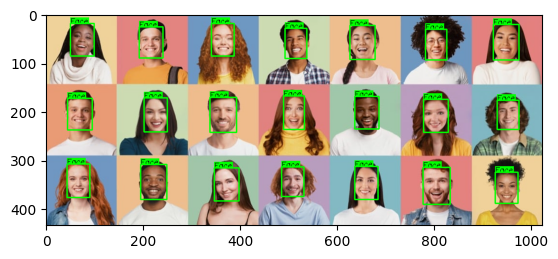

In [ ]:
face_bgr_np = cv2.imread(face_path)
face_rgb_np = cv2.cvtColor(face_bgr_np, cv2.COLOR_BGR2RGB)

face_boxes = face_detector.predict(face_rgb_np)[0]

for box in face_boxes:
  box.draw_label(face_rgb_np, "Face")
  box.draw_box(face_rgb_np)
plt.imshow(face_rgb_np)
plt.show()

In [ ]:
fish_bgr_np = cv2.imread(fish_path)
visulize_img_bgr = fish_bgr_np.copy()

visulize_img_rgb = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)
visulize_img = copy.deepcopy(visulize_img_rgb)


face_boxes = face_detector.predict(visulize_img_rgb)[0]

for box in face_boxes:
  box.draw_label(visulize_img, "Face")
  box.draw_box(visulize_img)
plt.imshow(visulize_img)
plt.show()

boxes = detector.predict(visulize_img_rgb)[0]

for box in boxes:
  cropped_fish_bgr = box.get_mask_BGR()
  cropped_fish_rgb = box.get_mask_RGB()
  segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]

  croped_fish_mask = segmented_polygons.mask_polygon(cropped_fish_rgb)

  segmented_polygons.move_to(box.x1, box.y1)
  segmented_polygons.draw_polygon(visulize_img)

  classification_result = classifier.batch_inference([cropped_fish_bgr])[0]

  # Ensure 'distance' key exists for all classification results before printing
  for item in classification_result:
      if 'distance' not in item:
          item['distance'] = 0.0

  label = f"{classification_result[0]['name']} | {round(classification_result[0]['accuracy'], 3)}" if len(classification_result) else "Not Found"
  box.draw_label(visulize_img, label)
  box.draw_box(visulize_img)

  print(50 * "=")
  plt.imshow(croped_fish_mask)
  plt.show()
  print_fish_data(classification_result)
plt.imshow(visulize_img)
plt.show()

NameError: name 'face_detector' is not defined

# FU

In [ ]:
import time
import cv2

# Image Load
face_bgr_np = img = cv2.imread(face_path)
face_rgb_np = cv2.cvtColor(face_bgr_np, cv2.COLOR_BGR2RGB)

fish_bgr_np = cv2.imread(fish_path)
fish_rgb_np = cv2.cvtColor(fish_bgr_np, cv2.COLOR_BGR2RGB)

times_array = []
for _ in range(3):
  start_time_complex = time.time()
  print(20 * "=")
  start_time = time.time()
  face_boxes = face_detector.predict(face_bgr_np)[0]
  end_time = time.time()
  print(f"Face detection time: {end_time - start_time:.4f} seconds")

  start_time = time.time()
  boxes = detector.predict(fish_bgr_np)[0]
  end_time = time.time()
  print(f"Fish detection time: {end_time - start_time:.4f} seconds")

  # Обработка каждого объекта
  for box in boxes:
      cropped_fish_bgr = box.get_mask_BGR()

      # Segmentation
      start_time = time.time()
      segmented_polygons = segmentator.predict(cropped_fish_bgr)[0]
      end_time = time.time()
      print(f"Segmentation time: {end_time - start_time:.4f} seconds")

      # Classification
      start_time = time.time()
      classification_result = classifier.batch_inference([cropped_fish_bgr])[0]
      end_time = time.time()
      print(f"Classification time: {end_time - start_time:.4f} seconds")
  times_array.append(time.time() - start_time_complex)

print(f"Average time: {sum(times_array)/len(times_array)}")

Face detection time: 0.1720 seconds
Fish detection time: 0.5893 seconds
Segmentation time: 0.5480 seconds
Classification time: 0.4566 seconds
Face detection time: 0.1739 seconds
Fish detection time: 0.4569 seconds
Segmentation time: 0.5175 seconds
Classification time: 0.3075 seconds
Face detection time: 0.1670 seconds
Fish detection time: 0.4652 seconds
Segmentation time: 0.5107 seconds
Classification time: 0.3078 seconds
Average time: 1.5578770637512207


## Face detection time execution test without postprocessing

In [ ]:
BATCH_SIZE = 10
start_time = time.time()
face_detector.model(torch.randn(BATCH_SIZE,3,640,640))
print(f"Mean face detection total time (Batch): {(time.time() - start_time)} seconds")

Mean face detection total time (Batch): 2.2078635692596436 seconds


## Fish detection time execution test without postprocessing

In [ ]:
BATCH_SIZE = 1
start_time = time.time()
detector.model(torch.randn(BATCH_SIZE,3,640,640))
print(f"Mean fish detection total time (Batch): {(time.time() - start_time)} seconds")


Mean fish detection total time (Batch): 0.742241382598877 seconds


## Fish Segmentation time execution test without postprocessing

In [ ]:
BATCH_SIZE = 5
start_time = time.time()
segmentator.model(torch.randn(BATCH_SIZE,3,416,416))
print(f"Fish segmentation total time (Batch): {(time.time() - start_time)} seconds")

Fish segmentation total time (Batch): 4.40203332901001 seconds


## Fish Classification time execution test without postprocessing

In [ ]:
BATCH_SIZE = 5
start_time = time.time()
classifier.model(torch.randn(BATCH_SIZE,3,224,224))
print(f"Fish Classification total time (Batch): {(time.time() - start_time)} seconds")

Fish Classification total time (Batch): 0.8921775817871094 seconds
